In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [5]:
train_data_dir  = '/content/drive/MyDrive/Final year Project/dataset/train'

classes = os.listdir(train_data_dir)
print(classes)

['plastic', 'metal', 'cardboard', 'glass', 'trash', 'paper', 'ps', 'pp', 'pet', 'pe-hd']


In [6]:
len(classes)

10

In [7]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor()])

train_ds = ImageFolder(train_data_dir, transform = transformations)

In [8]:
# average  = torch.Tensor([0,0,0])
# standard_dev = torch.Tensor([0,0,0])
# count =0

# for image in train_ds:
#   average += image[0].mean([1,2])
#   standard_dev += image[0].std([1,2])
#   count += 1
#   print(count)

In [9]:
def show_img(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  pet (5)


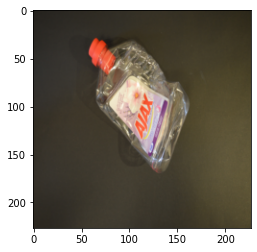

In [10]:
img, label = train_ds[2222]
show_img(img, label)

In [11]:
# stats = ((average / len(train_ds)).tolist(), (standard_dev / len(train_ds)).tolist())
# stats

In [12]:
stats = ([0.41108962893486023, 0.38021320104599, 0.33871954679489136],
 [0.1553582102060318, 0.1519845724105835, 0.1513998955488205])

In [13]:
train_tfms = transforms.Compose([transforms.Resize((227, 227)),
                          transforms.RandomHorizontalFlip(), 
                          transforms.ToTensor(), 
                          transforms.Normalize(*stats,inplace=True)
                        ])
valid_tfms = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor(), transforms.Normalize(*stats)
                        ])
test_tfms = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor(), transforms.Normalize(*stats)
                        ])
           

In [14]:
data_dir = "/content/drive/MyDrive/Final year Project/dataset"

In [15]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
val_ds = ImageFolder(data_dir+'/val', valid_tfms)
test_ds = ImageFolder(data_dir+'/test', test_tfms)

In [16]:
len(train_ds)

5055

In [35]:
batch_size = 128

In [36]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [37]:
import torch.nn as nn

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("epoch=",epoch+1)
        print("reslut =", result)
        print()

In [21]:
import torchvision.models as models

In [22]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(train_ds.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))



In [23]:
model = ResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [38]:
device = get_default_device()
device

device(type='cuda')

In [39]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def early_stopping_and_saving_model(val_loss,path = None):
  if path != None and val_loss < 1.50:
    torch.save(model, path)
  elif val_loss < 1.4925:
    return True 
    

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # # Gradient clipping
            # if grad_clip: 
            #     nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        #early stopping
        if early_stopping_and_saving_model(result['val_loss']) == True:
          break
    return history

In [28]:
import torch.nn.functional as F

In [29]:
val_history = [evaluate(model, val_dl)]
val_history

[{'val_loss': 2.3469042778015137, 'val_acc': 0.05745009332895279}]

In [30]:
epochs = 25
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [40]:
%%time
history=[]
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, grad_clip = grad_clip, weight_decay = weight_decay,
                             opt_func=opt_func)

epoch= 1
reslut = {'val_loss': 1.939215898513794, 'val_acc': 0.5673828125, 'train_loss': 2.0787789821624756, 'lrs': [1.9999999999999998e-05, 2.001324752108391e-05, 2.0052988621862167e-05, 2.0119218915075712e-05, 2.0211931089164767e-05, 2.03311149090751e-05, 2.047675721738874e-05, 2.0648841935776098e-05, 2.084735006677109e-05, 2.107225969586818e-05, 2.132354599394202e-05, 2.1601181219988125e-05, 2.1905134724185544e-05, 2.223537295128065e-05, 2.2591859444290937e-05, 2.297455484853039e-05, 2.3383416915953776e-05, 2.38184005098204e-05, 2.4279457609677787e-05, 2.476653731666199e-05, 2.527958585911731e-05, 2.5818546598532213e-05, 2.6383360035792027e-05, 2.6973963817747523e-05, 2.7590292744098194e-05, 2.8232278774590214e-05, 2.8899851036528177e-05, 2.9592935832598477e-05, 3.0311456649005706e-05, 3.10553341639194e-05, 3.182448625623066e-05, 3.261882801461818e-05, 3.343827174692195e-05, 3.4282726989824414e-05, 3.5152100518836844e-05, 3.6046296358591395e-05, 3.696521579343593e-05, 3.790875737833

In [ ]:
history


[{'val_loss': 2.2932956218719482, 'val_acc': 0.1692243367433548}]

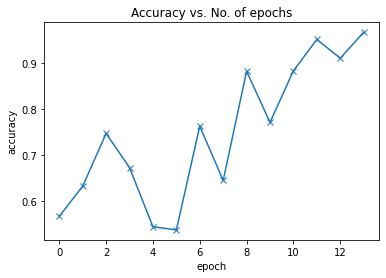

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

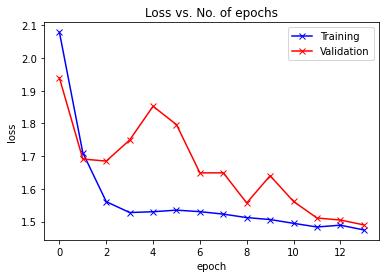

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [43]:
model_path = "/content/drive/MyDrive/Final year Project/model_state_30_dec.pt"

In [44]:
torch.save(model.state_dict(), model_path)

In [45]:
torch.save(model, "/content/drive/MyDrive/Final year Project/full_model_30_dec.pt")